In [1]:
import utils
import models
import numpy as np
import torch
import configs
import pgm_explainer as pe
from scipy.special import softmax
import pandas as pd
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

import argparse
    
def arg_parse():
    parser = argparse.ArgumentParser(description="Explainer arguments.")

    parser.add_argument(
            "--bmname", dest="bmname", help="Name of the benchmark dataset"
        )
    parser.add_argument("--dataset", dest="dataset", help="Input dataset.")
    parser.add_argument("--ckptdir", dest="ckptdir", help="Model checkpoint directory")
    parser.add_argument(
            "--gpu",
            dest="gpu",
            action="store_const",
            const=True,
            default=False,
            help="whether to use GPU.",
        )
    parser.add_argument(
            "--node-start", dest="node_start", type=int, help="Index of starting node."
        )
    parser.add_argument(
            "--node-end", dest="node_end", type=int, help="Index of ending node."
        )
    parser.add_argument(
            "--num-perturb-samples", dest="num_perturb_samples", type=int, help="Number of perturbed sample using to generate explanations."
        )
    parser.add_argument(
            "--top-node", dest="top_node", type=int, help="Number of nodes in explanation."
        )
    parser.add_argument(
            "--epochs", dest="num_epochs", type=int, help="Number of epochs to train."
        )
    parser.add_argument(
            "--hidden-dim", dest="hidden_dim", type=int, help="Hidden dimension"
        )
    parser.add_argument(
            "--output-dim", dest="output_dim", type=int, help="Output dimension"
        )
    parser.add_argument(
            "--num-gc-layers",
            dest="num_gc_layers",
            type=int,
            help="Number of graph convolution layers before each pooling",
        )
    parser.add_argument(
            "--bn",
            dest="bn",
            action="store_const",
            const=True,
            default=False,
            help="Whether batch normalization is used",
        )
    parser.add_argument("--dropout", dest="dropout", type=float, help="Dropout rate.")
    parser.add_argument(
            "--method", dest="method", type=str, help="Method. Possible values: base, att."
        )
    parser.add_argument(
            "--nobias",
            dest="bias",
            action="store_const",
            const=False,
            default=True,
            help="Whether to add bias. Default to True.",
        )
    
        # Explainer
   
    

    parser.set_defaults(
            ckptdir=None,
            dataset="syn1",
            opt="adam",  
            opt_scheduler="none",
            lr=0.1,
            clip=2.0,
            batch_size=20,
            num_epochs=100,
            hidden_dim=20,
            output_dim=20,
            num_gc_layers=3,
            method="base",
            dropout=0.0,
            node_start = None,
            node_end = None,
            num_perturb_samples = 100,
            top_node = None
        )
    
    return parser

d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prog_args = arg_parse()
args= prog_args.parse_args(['--dataset','syn1','--num-perturb-samples', '900','--top-node', '3'])

In [3]:
# Load model
A, X = utils.load_XA(args.dataset, datadir = "../Generate_XA_Data/XAL")
L = utils.load_labels(args.dataset, datadir = "../Generate_XA_Data/XAL")
num_classes = max(L) + 1
input_dim = X.shape[1]
num_nodes = X.shape[0]
ckpt = utils.load_ckpt(args)

print("input dim: ", input_dim, "; num classes: ", num_classes)
    
model = models.GcnEncoderNode(
        input_dim=input_dim,
        hidden_dim=args.hidden_dim,
        embedding_dim=args.output_dim,
        label_dim=num_classes,
        num_layers=args.num_gc_layers,
        bn=args.bn,
        args=args,
        )
model.load_state_dict(ckpt["model_state"]) 
pred = ckpt["save_data"]["pred"]

loading model
../Train_GNN_model/ckpt\syn1.pth.tar
=> loading checkpoint '../Train_GNN_model/ckpt\syn1.pth.tar'
input dim:  10 ; num classes:  4


In [4]:
import random
random.seed(21)

In [6]:
# Range of node to explain in this dataset is from 300 to 700
nodes_to_explain = list(range(400,700,5)) 

In [7]:
# Construct the explainer
explainer = pe.Node_Explainer(model, A, X, pred, 3)

Explainer settings
\ A dim:  (700, 700)
\ X dim:  (700, 10)
\ Number of layers:  3
\ Perturbation mode:  0
\ Print result:  1


In [10]:
import networkx as nx
import pylab as plt

def pgm_draw_nx(pgm_explanation):
    print("Draw pgm explaination using networkx")
    nx.draw(pgm_explanation, with_labels=True)
    plt.show()

def PGM_construct(pgm_explanation, target_name):
    loc = [(0, 0), (-5, -5), (5, -5), (5, 5), (-5,5)]
    pos = dict(zip(pgm_explanation.nodes(), loc))
    color_dict = dict(zip(range(pred.shape[2]), ['y','b','m','r']))
    color = [color_dict[ np.argmax(pred[0,int(node),:])] for node in pgm_explanation.nodes()]
    name_dict = [r'$A$',r'$B$',r'$C$',r'$D$',r'$E$']
    name = dict(zip(pgm_explanation.nodes(), name_dict))

    # gt_graph = nx.Graph()
    # gt_graph.add_nodes_from(pos.keys(), size=50)
    # edges_list = [('300', '301'),('301', '302'),('302', '300'),('303', '300'),('304', '300')]
    # gt_graph.add_edges_from(edges_list)

    # print("Ground truth explaination of node ", name[target_name])
    # figure1, ax1 = plt.subplots(figsize = (4,4))
    # ax1.axis('off')
    # nx.draw_networkx_nodes(gt_graph,pos,node_size=400,node_color= color)
    # nx.draw_networkx_edges(gt_graph,pos,
    #                     edgelist= edges_list,
    #                     width=2.0,alpha=1)
    # nx.draw_networkx_labels(gt_graph,pos,name,font_size=18, font_family = 'serif', font_weight = 'normal',
    #                         font_color = 'w')

    # # filename = 'view/motif_' + str(explained_node)+ '.jpg' 
    # # figure1.savefig(filename, dpi=90, bbox_inches='tight')

    print("PGM explaination of node ", name[target_name])

    figure2, ax = plt.subplots(figsize = (4,4))
    ax.axis('off')
    nx.draw_networkx_nodes(pgm_explanation,pos,node_size=400,node_color= color)
    nx.draw_networkx_edges(pgm_explanation,pos,
                        edgelist= pgm_explanation.edges,
                        connectionstyle='arc3, rad = 0.2',
                        width=2.0,alpha=0.8)
    nx.draw_networkx_labels(pgm_explanation,pos,name,font_size=18, font_family = 'serif', font_color = 'w')
    figure2.show()

    # filename = 'view/pgm_' + str(explained_node)+ '.jpg' 
    # figure2.savefig(filename, dpi=90, bbox_inches='tight')



--------------------------- Node 400 ---------------------------
Explaining node: 400
MK-blanket of target node: [404, 402, 400]
Generate the PGM
PGM Nodes:  ['404', '402', '400']
PGM Edges:  [('404', '400'), ('402', '404'), ('402', '400')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2344444444444444
Target's label is:  1
Probability that the target's label is 1 given ['404'] is 0.3017621145374449
Probability that the target's label is 1 given ['404', '402'] is 0.4460093896713615
Draw pgm explaination using networkx


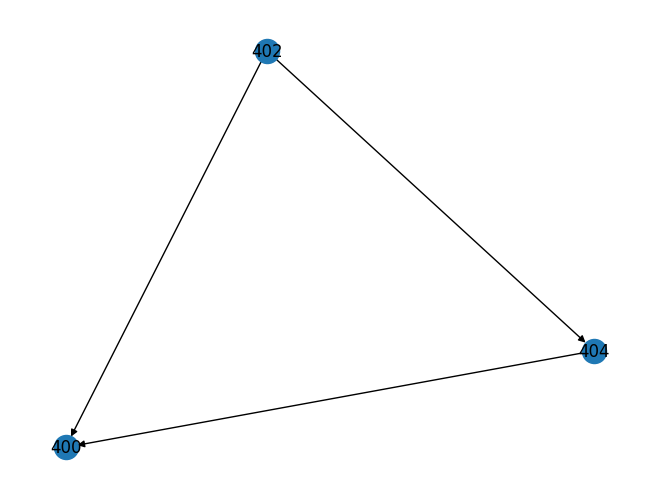

PGM explaination of node  $C$
--------------------------- Node 405 ---------------------------
Explaining node: 405


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [407, 405, 406]
Generate the PGM
PGM Nodes:  ['407', '406', '405']
PGM Edges:  [('407', '406'), ('407', '405'), ('406', '405')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.22666666666666666
Target's label is:  1
Probability that the target's label is 1 given ['407'] is 0.3009478672985782
Probability that the target's label is 1 given ['407', '406'] is 0.47692307692307695
Draw pgm explaination using networkx


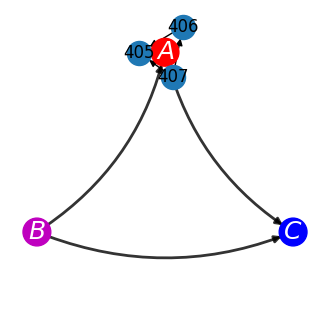

PGM explaination of node  $C$
--------------------------- Node 410 ---------------------------
Explaining node: 410


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [412, 410, 411]
Generate the PGM
PGM Nodes:  ['412', '411', '410']
PGM Edges:  [('412', '410'), ('411', '410')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2368373938073552
Target's label is:  1
Probability that the target's label is 1 given ['412'] is 0.3259122395396905
Probability that the target's label is 1 given ['412', '411'] is 0.4841628959276018
Draw pgm explaination using networkx


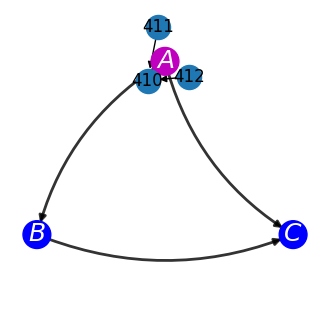

PGM explaination of node  $C$
--------------------------- Node 415 ---------------------------
Explaining node: 415


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [417, 415, 419]
Generate the PGM
PGM Nodes:  ['417', '419', '415']
PGM Edges:  [('417', '415'), ('419', '415')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2042794246943846
Target's label is:  1
Probability that the target's label is 1 given ['417'] is 0.2922169363748619
Probability that the target's label is 1 given ['417', '419'] is 0.4125560538116592
Draw pgm explaination using networkx


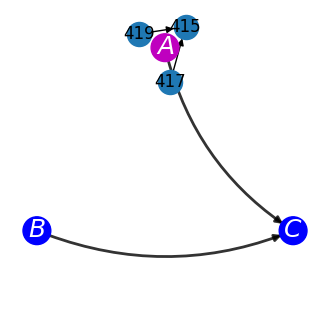

PGM explaination of node  $C$
--------------------------- Node 420 ---------------------------
Explaining node: 420


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [420, 422, 421]
Generate the PGM
PGM Nodes:  ['422', '421', '420']
PGM Edges:  [('422', '420'), ('421', '420')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2133190029621116
Target's label is:  1
Probability that the target's label is 1 given ['422'] is 0.28537004105468833
Probability that the target's label is 1 given ['422', '421'] is 0.44761904761904764
Draw pgm explaination using networkx


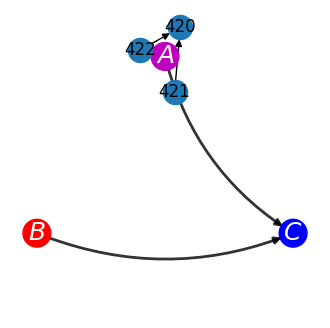

PGM explaination of node  $C$
--------------------------- Node 425 ---------------------------
Explaining node: 425


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [426, 427, 425]
Generate the PGM
PGM Nodes:  ['426', '427', '425']
PGM Edges:  [('426', '425'), ('427', '425')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.24663399670983835
Target's label is:  1
Probability that the target's label is 1 given ['426'] is 0.3361032769943661
Probability that the target's label is 1 given ['426', '427'] is 0.48514851485148514
Draw pgm explaination using networkx


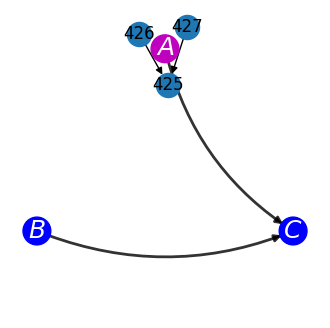

PGM explaination of node  $C$
--------------------------- Node 430 ---------------------------
Explaining node: 430


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [434, 432, 430]
Generate the PGM
PGM Nodes:  ['434', '432', '430']
PGM Edges:  [('434', '430'), ('432', '430')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.20585906270488208
Target's label is:  1
Probability that the target's label is 1 given ['434'] is 0.27202201535054715
Probability that the target's label is 1 given ['434', '432'] is 0.37305699481865284
Draw pgm explaination using networkx


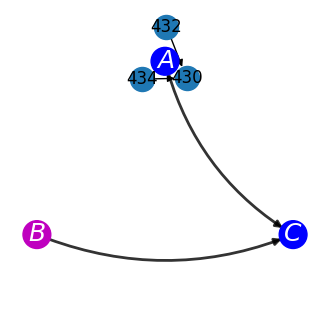

PGM explaination of node  $C$
--------------------------- Node 435 ---------------------------
Explaining node: 435


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [438, 437, 435]
Generate the PGM
PGM Nodes:  ['438', '437', '435']
PGM Edges:  [('438', '437'), ('438', '435'), ('437', '435')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.1677777777777778
Target's label is:  1
Probability that the target's label is 1 given ['438'] is 0.20459770114942533
Probability that the target's label is 1 given ['438', '437'] is 0.26976744186046514
Draw pgm explaination using networkx


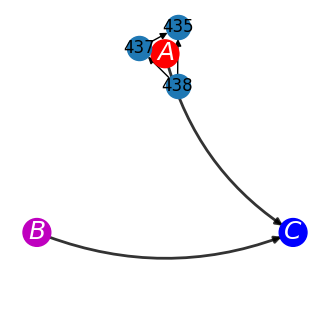

PGM explaination of node  $C$
--------------------------- Node 440 ---------------------------
Explaining node: 440


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [440, 442, 441]
Generate the PGM
PGM Nodes:  ['442', '441', '440']
PGM Edges:  [('442', '440'), ('441', '440')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2319445277916326
Target's label is:  1
Probability that the target's label is 1 given ['442'] is 0.3112983802216539
Probability that the target's label is 1 given ['442', '441'] is 0.4217391304347826
Draw pgm explaination using networkx


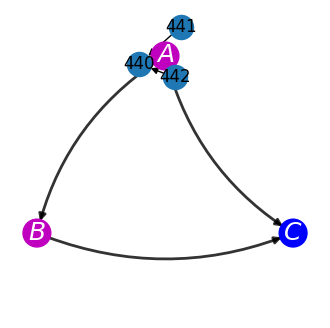

PGM explaination of node  $C$
--------------------------- Node 445 ---------------------------
Explaining node: 445


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [445, 446, 498]
Generate the PGM
PGM Nodes:  ['446', '498', '445']
PGM Edges:  [('446', '445'), ('498', '445')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.12552886949308195
Target's label is:  1
Probability that the target's label is 1 given ['446'] is 0.17405213555002585
Probability that the target's label is 1 given ['446', '498'] is 0.18376068376068377
Draw pgm explaination using networkx


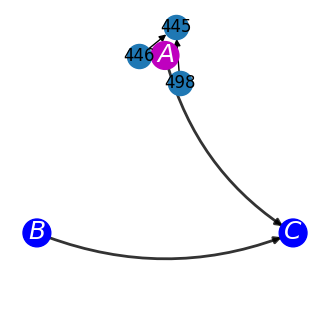

PGM explaination of node  $C$
--------------------------- Node 450 ---------------------------
Explaining node: 450


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [450, 452, 451]
Generate the PGM
PGM Nodes:  ['452', '451', '450']
PGM Edges:  [('452', '450'), ('451', '450')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2134946172716708
Target's label is:  1
Probability that the target's label is 1 given ['452'] is 0.2984964049631943
Probability that the target's label is 1 given ['452', '451'] is 0.44660194174757284
Draw pgm explaination using networkx


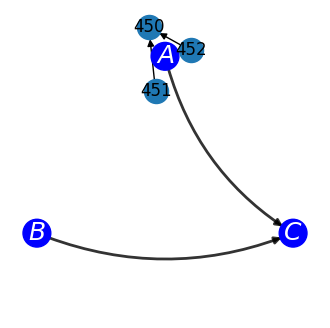

PGM explaination of node  $C$
--------------------------- Node 455 ---------------------------
Explaining node: 455


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [457, 455, 459]
Generate the PGM
PGM Nodes:  ['457', '459', '455']
PGM Edges:  [('457', '455'), ('459', '455')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.25018751483731694
Target's label is:  1
Probability that the target's label is 1 given ['457'] is 0.31069323144104805
Probability that the target's label is 1 given ['457', '459'] is 0.375
Draw pgm explaination using networkx


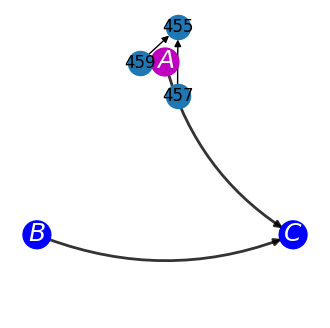

PGM explaination of node  $C$
--------------------------- Node 460 ---------------------------
Explaining node: 460


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [460, 462, 461]
Generate the PGM
PGM Nodes:  ['462', '461', '460']
PGM Edges:  [('462', '460'), ('461', '462'), ('461', '460')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2477777777777778
Target's label is:  1
Probability that the target's label is 1 given ['462'] is 0.3407079646017699
Probability that the target's label is 1 given ['462', '461'] is 0.48945147679324896
Draw pgm explaination using networkx


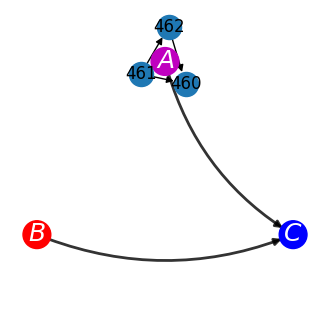

PGM explaination of node  $C$
--------------------------- Node 465 ---------------------------
Explaining node: 465


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [468, 465, 467]
Generate the PGM
PGM Nodes:  ['468', '467', '465']
PGM Edges:  [('468', '465'), ('467', '468'), ('467', '465')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2788888888888889
Target's label is:  1
Probability that the target's label is 1 given ['468'] is 0.3387096774193548
Probability that the target's label is 1 given ['468', '467'] is 0.4383561643835616
Draw pgm explaination using networkx


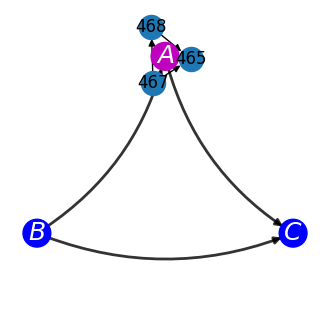

PGM explaination of node  $C$
--------------------------- Node 470 ---------------------------
Explaining node: 470


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [470, 472, 474]
Generate the PGM
PGM Nodes:  ['472', '474', '470']
PGM Edges:  [('472', '470'), ('474', '470')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2427973631936596
Target's label is:  1
Probability that the target's label is 1 given ['472'] is 0.34511883551673944
Probability that the target's label is 1 given ['472', '474'] is 0.45414847161572053
Draw pgm explaination using networkx


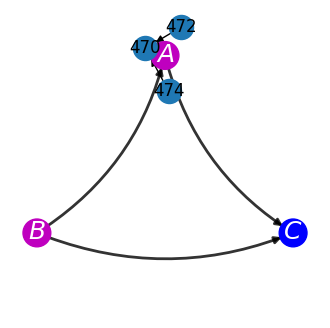

PGM explaination of node  $C$
--------------------------- Node 475 ---------------------------
Explaining node: 475


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [475, 477, 476]
Generate the PGM
PGM Nodes:  ['477', '476', '475']
PGM Edges:  [('477', '475'), ('476', '475')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.21476975191828143
Target's label is:  1
Probability that the target's label is 1 given ['477'] is 0.2979755816785105
Probability that the target's label is 1 given ['477', '476'] is 0.4523809523809524
Draw pgm explaination using networkx


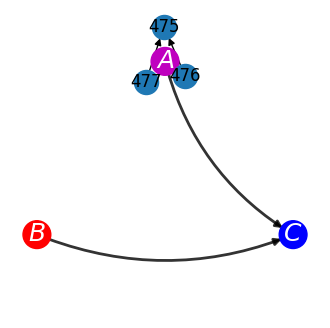

PGM explaination of node  $C$
--------------------------- Node 480 ---------------------------
Explaining node: 480


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [480, 482, 483]
Generate the PGM
PGM Nodes:  ['482', '483', '480']
PGM Edges:  [('482', '480'), ('483', '482'), ('483', '480')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.36333333333333334
Target's label is:  1
Probability that the target's label is 1 given ['482'] is 0.4276729559748428
Probability that the target's label is 1 given ['482', '483'] is 0.47346938775510206
Draw pgm explaination using networkx


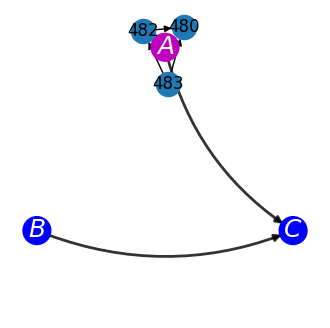

PGM explaination of node  $C$
--------------------------- Node 485 ---------------------------
Explaining node: 485


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [487, 485, 486]
Generate the PGM
PGM Nodes:  ['487', '486', '485']
PGM Edges:  [('487', '485'), ('486', '485')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.16095033645496126
Target's label is:  1
Probability that the target's label is 1 given ['487'] is 0.22365374824996817
Probability that the target's label is 1 given ['487', '486'] is 0.32407407407407407
Draw pgm explaination using networkx


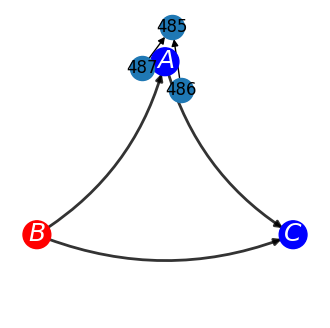

PGM explaination of node  $C$
--------------------------- Node 490 ---------------------------
Explaining node: 490


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [490, 492, 493]
Generate the PGM
PGM Nodes:  ['492', '493', '490']
PGM Edges:  [('492', '490'), ('493', '492'), ('493', '490')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.21666666666666667
Target's label is:  1
Probability that the target's label is 1 given ['492'] is 0.2954545454545454
Probability that the target's label is 1 given ['492', '493'] is 0.3472222222222222
Draw pgm explaination using networkx


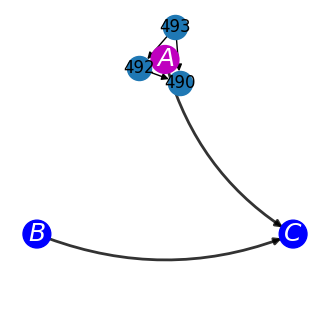

PGM explaination of node  $C$
--------------------------- Node 495 ---------------------------
Explaining node: 495


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [496, 495, 448]
Generate the PGM
PGM Nodes:  ['496', '448', '495']
PGM Edges:  [('496', '495'), ('448', '495')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.1232817568496969
Target's label is:  1
Probability that the target's label is 1 given ['496'] is 0.16935654037109518
Probability that the target's label is 1 given ['496', '448'] is 0.16517857142857142
Draw pgm explaination using networkx


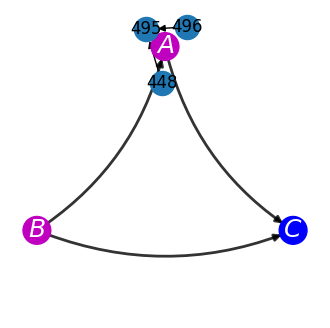

PGM explaination of node  $C$
--------------------------- Node 500 ---------------------------
Explaining node: 500


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [502, 500, 504]
Generate the PGM
PGM Nodes:  ['502', '504', '500']
PGM Edges:  [('502', '500'), ('504', '500')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.248103532639185
Target's label is:  1
Probability that the target's label is 1 given ['502'] is 0.32279647205445305
Probability that the target's label is 1 given ['502', '504'] is 0.42105263157894735
Draw pgm explaination using networkx


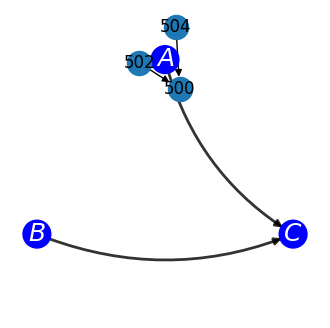

PGM explaination of node  $C$
--------------------------- Node 505 ---------------------------
Explaining node: 505


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [507, 506, 505]
Generate the PGM
PGM Nodes:  ['507', '506', '505']
PGM Edges:  [('507', '506'), ('507', '505'), ('506', '505')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.21333333333333332
Target's label is:  1
Probability that the target's label is 1 given ['507'] is 0.3004694835680751
Probability that the target's label is 1 given ['507', '506'] is 0.475
Draw pgm explaination using networkx


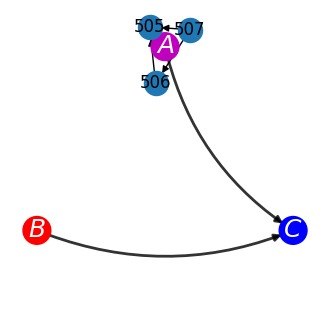

PGM explaination of node  $C$
--------------------------- Node 510 ---------------------------
Explaining node: 510


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [514, 510, 511]
Generate the PGM
PGM Nodes:  ['514', '511', '510']
PGM Edges:  [('514', '511'), ('514', '510'), ('511', '510')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.14555555555555558
Target's label is:  1
Probability that the target's label is 1 given ['514'] is 0.19565217391304351
Probability that the target's label is 1 given ['514', '511'] is 0.25462962962962965
Draw pgm explaination using networkx


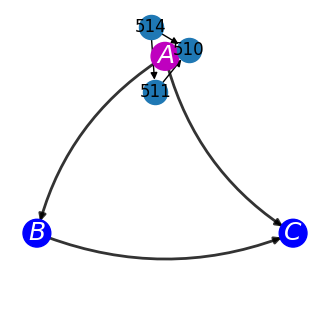

PGM explaination of node  $C$
--------------------------- Node 515 ---------------------------
Explaining node: 515


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [515, 517, 519]
Generate the PGM
PGM Nodes:  ['517', '519', '515']
PGM Edges:  [('517', '515'), ('519', '515')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.21797939562866087
Target's label is:  1
Probability that the target's label is 1 given ['517'] is 0.29495465498541956
Probability that the target's label is 1 given ['517', '519'] is 0.4034334763948498
Draw pgm explaination using networkx


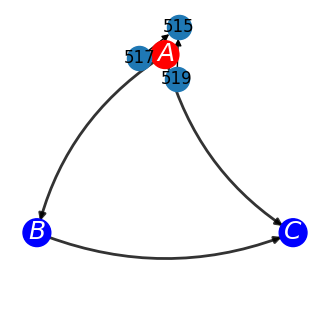

PGM explaination of node  $C$
--------------------------- Node 520 ---------------------------
Explaining node: 520


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [522, 521, 520]
Generate the PGM
PGM Nodes:  ['522', '521', '520']
PGM Edges:  [('522', '520'), ('521', '520')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.23412084706003938
Target's label is:  1
Probability that the target's label is 1 given ['522'] is 0.3140534022394488
Probability that the target's label is 1 given ['522', '521'] is 0.4666666666666667
Draw pgm explaination using networkx


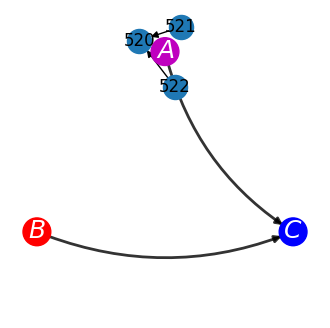

PGM explaination of node  $C$
--------------------------- Node 525 ---------------------------
Explaining node: 525


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [526, 527, 525]
Generate the PGM
PGM Nodes:  ['526', '527', '525']
PGM Edges:  [('526', '525'), ('527', '526'), ('527', '525')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2433333333333333
Target's label is:  1
Probability that the target's label is 1 given ['526'] is 0.33109619686800895
Probability that the target's label is 1 given ['526', '527'] is 0.46808510638297873
Draw pgm explaination using networkx


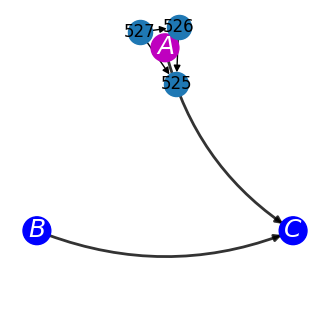

PGM explaination of node  $C$
--------------------------- Node 530 ---------------------------
Explaining node: 530


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [530, 532, 531]
Generate the PGM
PGM Nodes:  ['532', '531', '530']
PGM Edges:  [('532', '530'), ('531', '532'), ('531', '530')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.31222222222222223
Target's label is:  1
Probability that the target's label is 1 given ['532'] is 0.3644251626898048
Probability that the target's label is 1 given ['532', '531'] is 0.48333333333333334
Draw pgm explaination using networkx


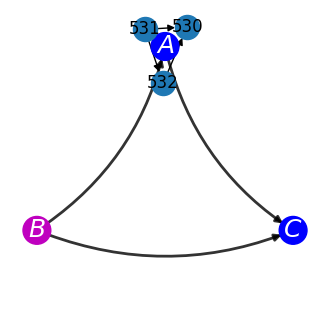

PGM explaination of node  $C$
--------------------------- Node 535 ---------------------------
Explaining node: 535


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [537, 535, 536]
Generate the PGM
PGM Nodes:  ['537', '536', '535']
PGM Edges:  [('537', '535'), ('536', '535')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.25234048897224987
Target's label is:  1
Probability that the target's label is 1 given ['537'] is 0.33986676204101096
Probability that the target's label is 1 given ['537', '536'] is 0.46
Draw pgm explaination using networkx


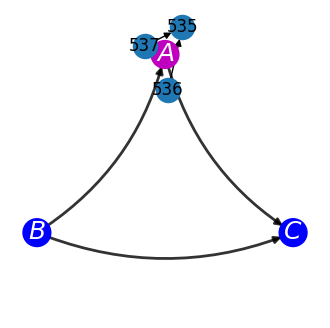

PGM explaination of node  $C$
--------------------------- Node 540 ---------------------------
Explaining node: 540


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [541, 542, 540]
Generate the PGM
PGM Nodes:  ['541', '542', '540']
PGM Edges:  [('541', '540'), ('542', '540')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.23695374617852977
Target's label is:  1
Probability that the target's label is 1 given ['541'] is 0.36450574473975633
Probability that the target's label is 1 given ['541', '542'] is 0.48660714285714285
Draw pgm explaination using networkx


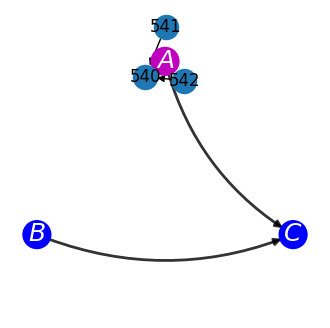

PGM explaination of node  $C$
--------------------------- Node 545 ---------------------------
Explaining node: 545


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [546, 547, 545]
Generate the PGM
PGM Nodes:  ['546', '547', '545']
PGM Edges:  [('546', '545'), ('547', '545')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2525250244093259
Target's label is:  1
Probability that the target's label is 1 given ['546'] is 0.3596267275263091
Probability that the target's label is 1 given ['546', '547'] is 0.49372384937238495
Draw pgm explaination using networkx


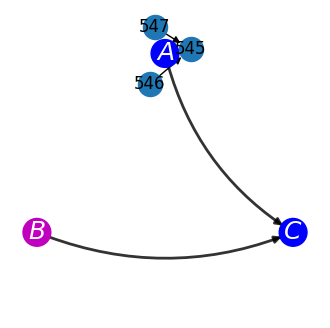

PGM explaination of node  $C$
--------------------------- Node 550 ---------------------------
Explaining node: 550


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [550, 551, 554]
Generate the PGM
PGM Nodes:  ['551', '554', '550']
PGM Edges:  [('551', '554'), ('551', '550'), ('554', '550')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.1288888888888889
Target's label is:  1
Probability that the target's label is 1 given ['551'] is 0.1794871794871795
Probability that the target's label is 1 given ['551', '554'] is 0.2450592885375494
Draw pgm explaination using networkx


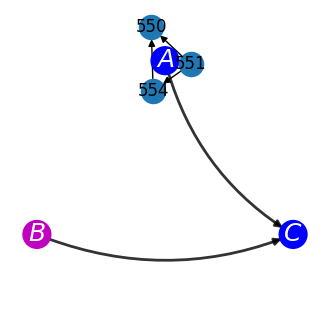

PGM explaination of node  $C$
--------------------------- Node 555 ---------------------------
Explaining node: 555


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [555, 557, 556]
Generate the PGM
PGM Nodes:  ['557', '556', '555']
PGM Edges:  [('557', '555'), ('556', '557'), ('556', '555')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.24666666666666665
Target's label is:  1
Probability that the target's label is 1 given ['557'] is 0.3191489361702128
Probability that the target's label is 1 given ['557', '556'] is 0.4256198347107438
Draw pgm explaination using networkx


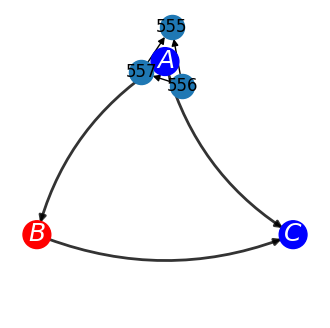

PGM explaination of node  $C$
--------------------------- Node 560 ---------------------------
Explaining node: 560


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [560, 562, 561]
Generate the PGM
PGM Nodes:  ['562', '561', '560']
PGM Edges:  [('562', '560'), ('561', '560')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2288469664971281
Target's label is:  1
Probability that the target's label is 1 given ['562'] is 0.28765422077922076
Probability that the target's label is 1 given ['562', '561'] is 0.39732142857142855
Draw pgm explaination using networkx


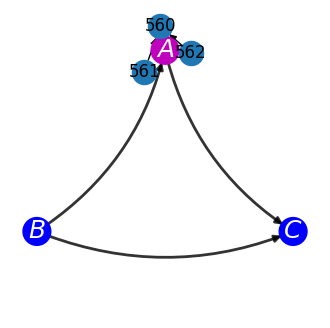

PGM explaination of node  $C$
--------------------------- Node 565 ---------------------------
Explaining node: 565


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [565, 567, 566]
Generate the PGM
PGM Nodes:  ['567', '566', '565']
PGM Edges:  [('567', '566'), ('567', '565'), ('566', '565')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2688888888888889
Target's label is:  1
Probability that the target's label is 1 given ['567'] is 0.3693304535637149
Probability that the target's label is 1 given ['567', '566'] is 0.49809885931558934
Draw pgm explaination using networkx


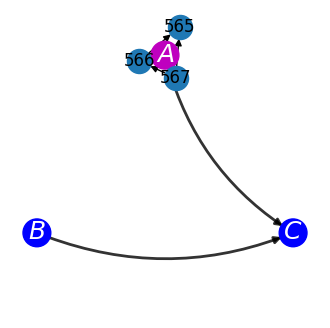

PGM explaination of node  $C$
--------------------------- Node 570 ---------------------------
Explaining node: 570


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [572, 574, 570]
Generate the PGM
PGM Nodes:  ['572', '574', '570']
PGM Edges:  [('572', '570'), ('574', '570')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2079358406421074
Target's label is:  1
Probability that the target's label is 1 given ['572'] is 0.3059045504994451
Probability that the target's label is 1 given ['572', '574'] is 0.4117647058823529
Draw pgm explaination using networkx


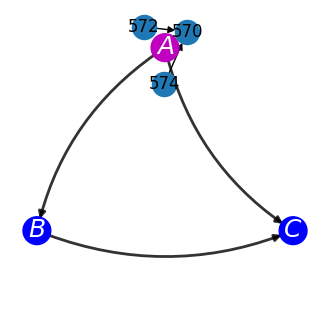

PGM explaination of node  $C$
--------------------------- Node 575 ---------------------------
Explaining node: 575


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [577, 575, 579]
Generate the PGM
PGM Nodes:  ['577', '579', '575']
PGM Edges:  [('577', '575'), ('579', '575')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.22274267902896228
Target's label is:  1
Probability that the target's label is 1 given ['577'] is 0.29822383469442293
Probability that the target's label is 1 given ['577', '579'] is 0.3755656108597285
Draw pgm explaination using networkx


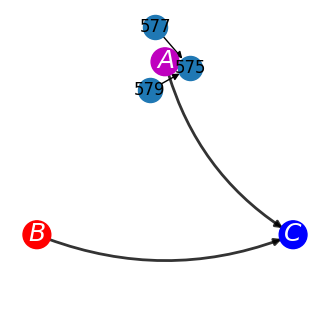

PGM explaination of node  $C$
--------------------------- Node 580 ---------------------------
Explaining node: 580


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [580, 582, 584]
Generate the PGM
PGM Nodes:  ['582', '584', '580']
PGM Edges:  [('582', '580'), ('584', '580')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.25028341361892
Target's label is:  1
Probability that the target's label is 1 given ['582'] is 0.32424324443562086
Probability that the target's label is 1 given ['582', '584'] is 0.3607305936073059
Draw pgm explaination using networkx


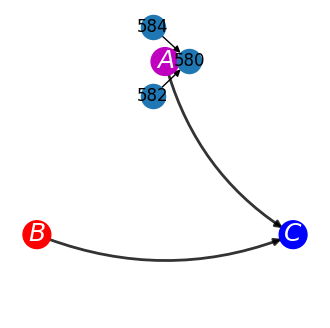

PGM explaination of node  $C$
--------------------------- Node 585 ---------------------------
Explaining node: 585


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [585, 587, 588]
Generate the PGM
PGM Nodes:  ['587', '588', '585']
PGM Edges:  [('587', '588'), ('587', '585'), ('588', '585')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.15333333333333332
Target's label is:  1
Probability that the target's label is 1 given ['587'] is 0.22368421052631582
Probability that the target's label is 1 given ['587', '588'] is 0.2943722943722944
Draw pgm explaination using networkx


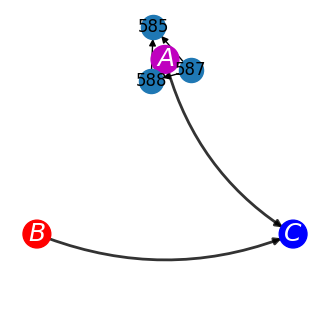

PGM explaination of node  $C$
--------------------------- Node 590 ---------------------------
Explaining node: 590


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [590, 592, 594]
Generate the PGM
PGM Nodes:  ['592', '594', '590']
PGM Edges:  [('592', '590'), ('594', '590')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.225510629229411
Target's label is:  1
Probability that the target's label is 1 given ['592'] is 0.3107115648226599
Probability that the target's label is 1 given ['592', '594'] is 0.36771300448430494
Draw pgm explaination using networkx


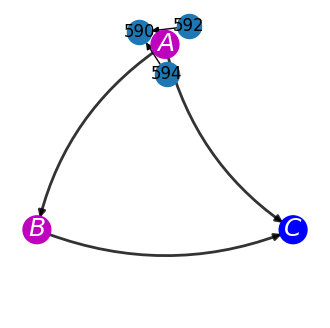

PGM explaination of node  $C$
--------------------------- Node 595 ---------------------------
Explaining node: 595


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [596, 597, 595]
Generate the PGM
PGM Nodes:  ['596', '597', '595']
PGM Edges:  [('596', '595'), ('597', '595')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.23230229584284023
Target's label is:  1
Probability that the target's label is 1 given ['596'] is 0.3090275001850618
Probability that the target's label is 1 given ['596', '597'] is 0.39035087719298245
Draw pgm explaination using networkx


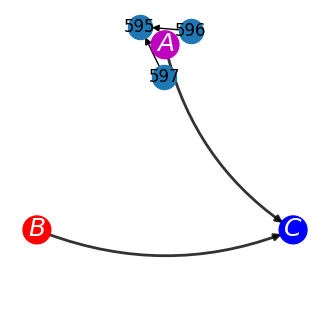

PGM explaination of node  $C$
--------------------------- Node 600 ---------------------------
Explaining node: 600


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [600, 602, 601]
Generate the PGM
PGM Nodes:  ['602', '601', '600']
PGM Edges:  [('602', '600'), ('601', '600')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2967958443830193
Target's label is:  1
Probability that the target's label is 1 given ['602'] is 0.3681347410759176
Probability that the target's label is 1 given ['602', '601'] is 0.4434389140271493
Draw pgm explaination using networkx


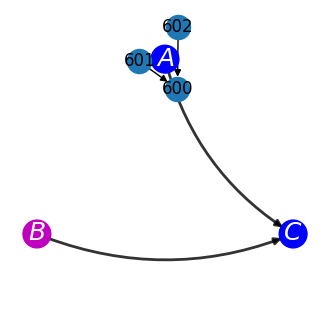

PGM explaination of node  $C$
--------------------------- Node 605 ---------------------------
Explaining node: 605


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [606, 607, 605]
Generate the PGM
PGM Nodes:  ['606', '607', '605']
PGM Edges:  [('606', '605'), ('607', '605')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.25200800508485055
Target's label is:  1
Probability that the target's label is 1 given ['606'] is 0.3539392683269104
Probability that the target's label is 1 given ['606', '607'] is 0.5148936170212766
Draw pgm explaination using networkx


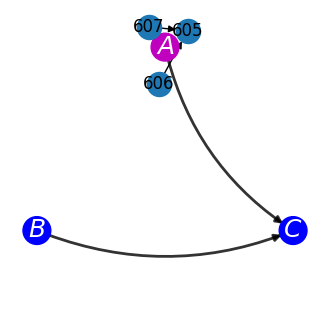

PGM explaination of node  $C$
--------------------------- Node 610 ---------------------------
Explaining node: 610


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [610, 612, 614]
Generate the PGM
PGM Nodes:  ['612', '614', '610']
PGM Edges:  [('612', '610'), ('614', '610')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2303558544925876
Target's label is:  1
Probability that the target's label is 1 given ['612'] is 0.2869726281127804
Probability that the target's label is 1 given ['612', '614'] is 0.3274336283185841
Draw pgm explaination using networkx


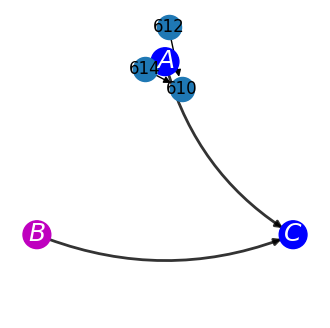

PGM explaination of node  $C$
--------------------------- Node 615 ---------------------------
Explaining node: 615


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [617, 615, 619]
Generate the PGM
PGM Nodes:  ['617', '619', '615']
PGM Edges:  [('617', '615'), ('619', '615')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.23306816267621594
Target's label is:  1
Probability that the target's label is 1 given ['617'] is 0.3279149674801849
Probability that the target's label is 1 given ['617', '619'] is 0.4199134199134199
Draw pgm explaination using networkx


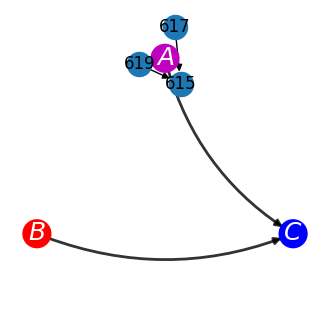

PGM explaination of node  $C$
--------------------------- Node 620 ---------------------------
Explaining node: 620


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [622, 620, 621]
Generate the PGM
PGM Nodes:  ['622', '621', '620']
PGM Edges:  [('622', '620'), ('621', '620')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.28323006081954005
Target's label is:  1
Probability that the target's label is 1 given ['622'] is 0.355411973918198
Probability that the target's label is 1 given ['622', '621'] is 0.4979253112033195
Draw pgm explaination using networkx


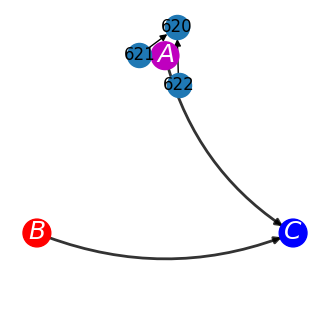

PGM explaination of node  $C$
--------------------------- Node 625 ---------------------------
Explaining node: 625


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [625, 627, 629]
Generate the PGM
PGM Nodes:  ['627', '629', '625']
PGM Edges:  [('627', '625'), ('629', '625')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.23533129744052725
Target's label is:  1
Probability that the target's label is 1 given ['627'] is 0.33375286791215997
Probability that the target's label is 1 given ['627', '629'] is 0.40707964601769914
Draw pgm explaination using networkx


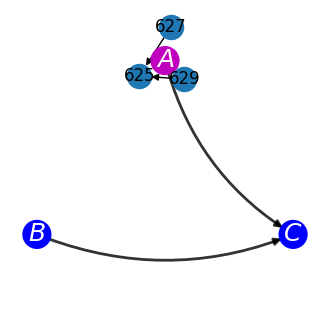

PGM explaination of node  $C$
--------------------------- Node 630 ---------------------------
Explaining node: 630


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [632, 630, 633]
Generate the PGM
PGM Nodes:  ['632', '633', '630']
PGM Edges:  [('632', '630'), ('633', '632'), ('633', '630')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.1622222222222222
Target's label is:  1
Probability that the target's label is 1 given ['632'] is 0.21881838074398252
Probability that the target's label is 1 given ['632', '633'] is 0.3056768558951965
Draw pgm explaination using networkx


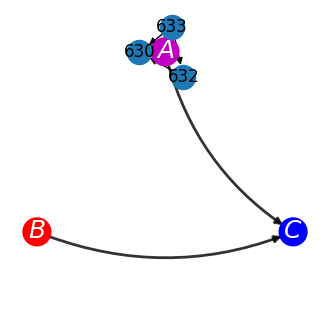

PGM explaination of node  $C$
--------------------------- Node 635 ---------------------------
Explaining node: 635


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [636, 637, 635]
Generate the PGM
PGM Nodes:  ['636', '637', '635']
PGM Edges:  [('636', '635'), ('637', '635')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.25831046547079184
Target's label is:  1
Probability that the target's label is 1 given ['636'] is 0.3466330953595105
Probability that the target's label is 1 given ['636', '637'] is 0.4864864864864865
Draw pgm explaination using networkx


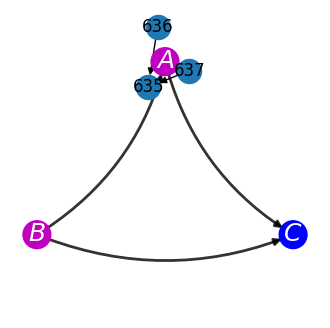

PGM explaination of node  $C$
--------------------------- Node 640 ---------------------------
Explaining node: 640


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [642, 644, 640]
Generate the PGM
PGM Nodes:  ['642', '644', '640']
PGM Edges:  [('642', '640'), ('644', '640')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2363684876657934
Target's label is:  1
Probability that the target's label is 1 given ['642'] is 0.3258403809130913
Probability that the target's label is 1 given ['642', '644'] is 0.43564356435643564
Draw pgm explaination using networkx


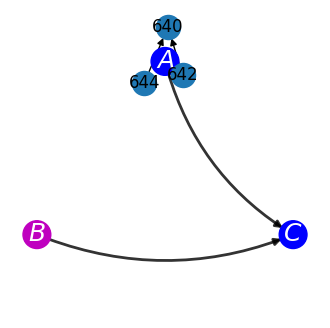

PGM explaination of node  $C$
--------------------------- Node 645 ---------------------------
Explaining node: 645


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [645, 647, 649]
Generate the PGM
PGM Nodes:  ['647', '649', '645']
PGM Edges:  [('647', '645'), ('649', '645')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.260808328764807
Target's label is:  1
Probability that the target's label is 1 given ['647'] is 0.37183221832855473
Probability that the target's label is 1 given ['647', '649'] is 0.4520547945205479
Draw pgm explaination using networkx


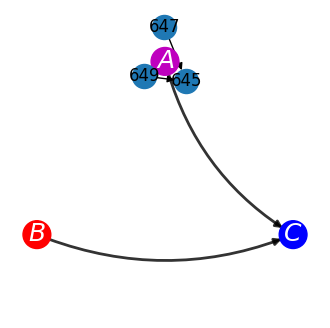

PGM explaination of node  $C$
--------------------------- Node 650 ---------------------------
Explaining node: 650


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [650, 652, 651]
Generate the PGM
PGM Nodes:  ['652', '651', '650']
PGM Edges:  [('652', '650'), ('651', '650')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2773558627752176
Target's label is:  1
Probability that the target's label is 1 given ['652'] is 0.3443932411674347
Probability that the target's label is 1 given ['652', '651'] is 0.46774193548387094
Draw pgm explaination using networkx


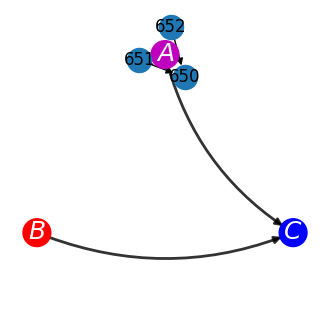

PGM explaination of node  $C$
--------------------------- Node 655 ---------------------------
Explaining node: 655


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [657, 655, 659]
Generate the PGM
PGM Nodes:  ['657', '659', '655']
PGM Edges:  [('657', '655'), ('659', '655')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.22459921424901508
Target's label is:  1
Probability that the target's label is 1 given ['657'] is 0.28910461760461764
Probability that the target's label is 1 given ['657', '659'] is 0.35064935064935066
Draw pgm explaination using networkx


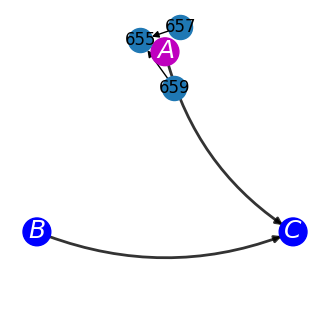

PGM explaination of node  $C$
--------------------------- Node 660 ---------------------------
Explaining node: 660


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [660, 662, 661]
Generate the PGM
PGM Nodes:  ['662', '661', '660']
PGM Edges:  [('662', '660'), ('661', '660')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.4810185809513556
Target's label is:  1
Probability that the target's label is 1 given ['662'] is 0.5242297607341855
Probability that the target's label is 1 given ['662', '661'] is 0.5752212389380531
Draw pgm explaination using networkx


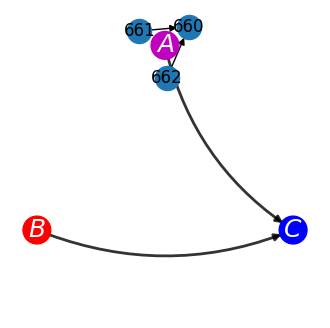

PGM explaination of node  $C$
--------------------------- Node 665 ---------------------------
Explaining node: 665


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [667, 665, 666]
Generate the PGM
PGM Nodes:  ['667', '666', '665']
PGM Edges:  [('667', '665'), ('666', '665')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.25646558530064695
Target's label is:  1
Probability that the target's label is 1 given ['667'] is 0.33373466127191614
Probability that the target's label is 1 given ['667', '666'] is 0.4327731092436975
Draw pgm explaination using networkx


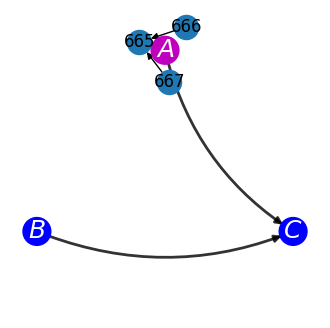

PGM explaination of node  $C$
--------------------------- Node 670 ---------------------------
Explaining node: 670


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [670, 672, 674]
Generate the PGM
PGM Nodes:  ['672', '674', '670']
PGM Edges:  [('672', '670'), ('674', '670')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2460740603431963
Target's label is:  1
Probability that the target's label is 1 given ['672'] is 0.3432222903467539
Probability that the target's label is 1 given ['672', '674'] is 0.44537815126050423
Draw pgm explaination using networkx


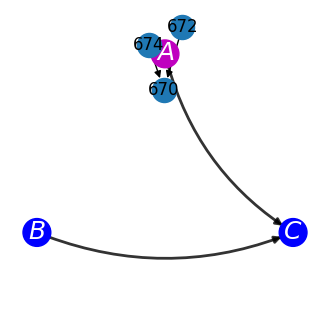

PGM explaination of node  $C$
--------------------------- Node 675 ---------------------------
Explaining node: 675


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [675, 676, 677]
Generate the PGM
PGM Nodes:  ['676', '677', '675']
PGM Edges:  [('676', '675'), ('677', '675')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.22823906624956988
Target's label is:  1
Probability that the target's label is 1 given ['676'] is 0.331900592180966
Probability that the target's label is 1 given ['676', '677'] is 0.4719626168224299
Draw pgm explaination using networkx


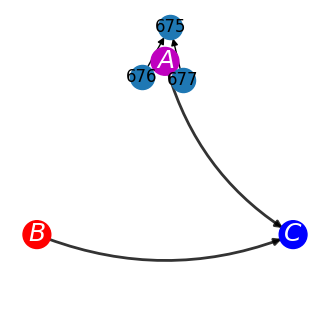

PGM explaination of node  $C$
--------------------------- Node 680 ---------------------------
Explaining node: 680


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [680, 682, 683]
Generate the PGM
PGM Nodes:  ['682', '683', '680']
PGM Edges:  [('682', '680'), ('683', '682'), ('683', '680')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.26222222222222225
Target's label is:  1
Probability that the target's label is 1 given ['682'] is 0.3401360544217687
Probability that the target's label is 1 given ['682', '683'] is 0.3728813559322034
Draw pgm explaination using networkx


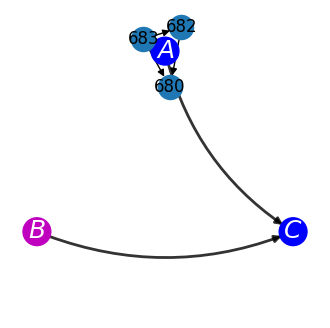

PGM explaination of node  $C$
--------------------------- Node 685 ---------------------------
Explaining node: 685


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [685, 687, 689]
Generate the PGM
PGM Nodes:  ['687', '689', '685']
PGM Edges:  [('687', '689'), ('687', '685'), ('689', '685')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.2188888888888889
Target's label is:  1
Probability that the target's label is 1 given ['687'] is 0.31627906976744186
Probability that the target's label is 1 given ['687', '689'] is 0.39090909090909093
Draw pgm explaination using networkx


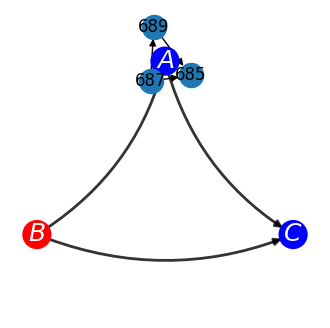

PGM explaination of node  $C$
--------------------------- Node 690 ---------------------------
Explaining node: 690


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [690, 694, 682]
Generate the PGM
PGM Nodes:  ['694', '682', '690']
PGM Edges:  [('694', '690'), ('682', '690')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.13962227699958485
Target's label is:  1
Probability that the target's label is 1 given ['694'] is 0.18418728004022122
Probability that the target's label is 1 given ['694', '682'] is 0.21923076923076923
Draw pgm explaination using networkx


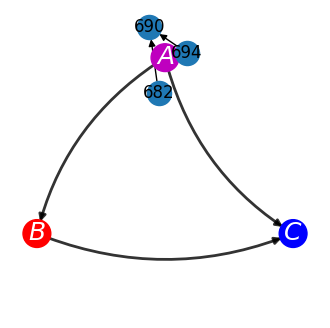

PGM explaination of node  $C$
--------------------------- Node 695 ---------------------------
Explaining node: 695


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


MK-blanket of target node: [699, 695, 697]
Generate the PGM
PGM Nodes:  ['699', '697', '695']
PGM Edges:  [('699', '695'), ('697', '695')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.20255291611571272
Target's label is:  1
Probability that the target's label is 1 given ['699'] is 0.2575617937391638
Probability that the target's label is 1 given ['699', '697'] is 0.3440366972477064
Draw pgm explaination using networkx


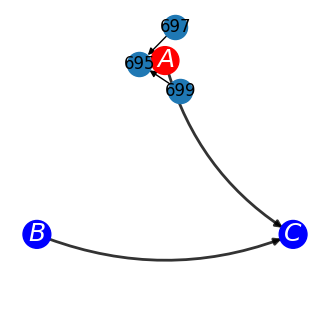

PGM explaination of node  $C$


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


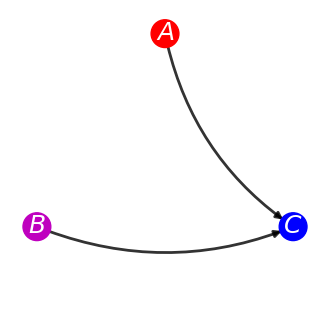

In [11]:
# Explaining each target node
for target in nodes_to_explain:
    print(f"--------------------------- Node {target} ---------------------------")
    # Explaining the target node
    subnodes, data, stats = explainer.explain(target, num_samples = 900, top_node = 3, pred_threshold = 0.2)
    # Markov Blanket of target node
    print("MK-blanket of target node:", subnodes)
    
    # Generating the Probabilistic Graph
    print("Generate the PGM")
    pgm_explanation = explainer.pgm_generate(target, data, stats, subnodes)
    print("PGM Nodes: ", pgm_explanation.nodes())
    print("PGM Edges: ", pgm_explanation.edges())

    # Conversion of target names for preventing type mismatch
    print("The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience")
    target_name = str(target)
    explaining_nodes = [node for node in pgm_explanation.nodes() if node != target_name]

    # Computing marginal probability of target prediction with no observation
    print("Compute marginal probability of the target prediction with no observation")
    marginal_prob = explainer.pgm_conditional_prob(target_name, pgm_explanation, [])
    print(marginal_prob)

    # Computing other probabilities
    target_label = np.argmax(pred[0,target])
    print("Target's label is: ", target_label)
    for num_of_evidence in range(len(explaining_nodes)):
        cond_prob = explainer.pgm_conditional_prob(target_name, pgm_explanation, explaining_nodes[0:num_of_evidence+1])
        print("Probability that the target's label is {} given {} is {}".format(target_label,
                                                                                explaining_nodes[0:num_of_evidence+1],
                                                                            cond_prob))
    

    # Drawing pgm explanation
    pgm_draw_nx(pgm_explanation)
    PGM_construct(pgm_explanation, target_name)